In [95]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

In [96]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [97]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [98]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [99]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(autoload_with=engine)

In [100]:
# View all of the classes that automap found
Base.classes.keys()

['station', 'measurement']

In [101]:
# Save references to each table
station = Base.classes.station
measurement = Base.classes.measurement

In [102]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [103]:
# Find the most recent date in the data set.

session.query(measurement.date).order_by(measurement.date.desc()).first()

('2017-08-23',)

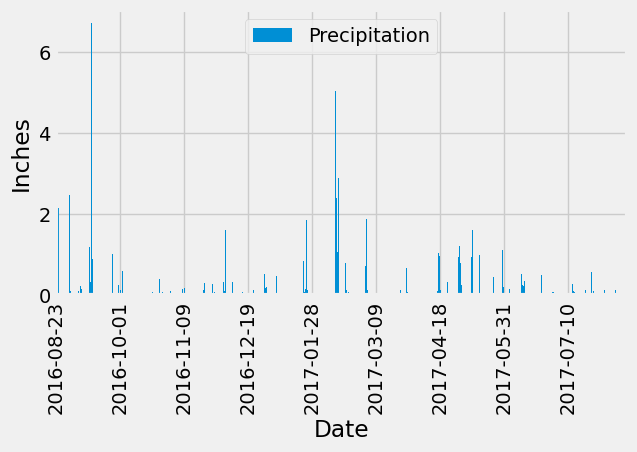

In [106]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
latest_date_result = session.query(measurement.date).order_by(measurement.date.desc()).first()
latest_date = dt.datetime.strptime(latest_date_result[0], "%Y-%m-%d").date()
latest_date 

# Calculate the date one year from the last date in data set.
year_ago = latest_date - dt.timedelta(days=365)
year_ago

# Perform a query to retrieve the data and precipitation scores

session.query(measurement.date, measurement.prcp).\
    filter(measurement.date >= year_ago).\
    order_by(measurement.date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names

precipitation_data = session.query(measurement.date, measurement.prcp).\
    filter(measurement.date >= year_ago).\
    order_by(measurement.date).all()
precipitation_data_df = pd.DataFrame(precipitation_data, columns=['Date', 'Precipitation'])

# Sort the dataframe by date
precipitation_data_df = precipitation_data_df.sort_values(by='Date')
precipitation_data_df
# Use Pandas Plotting with Matplotlib to plot the data

precipitation_data_df.set_index('Date', inplace=True)
ax = precipitation_data_df.plot.bar()
plt.tight_layout()
plt.xlabel('Date')
plt.ylabel('Inches')

#Set the x-axis tick positions and labels
nbins = 9  
ax.xaxis.set_major_locator(MaxNLocator(nbins=nbins))

plt.show()

In [ ]:
# Use Pandas to calculate the summary statistics for the precipitation data


# Exploratory Station Analysis

In [ ]:
# Design a query to calculate the total number of stations in the dataset


In [ ]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.


In [ ]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.


In [ ]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram


# Close Session

In [ ]:
# Close Session
session.close()

NameError: name 'session' is not defined